In [1]:
from IPython.display import display, Image, HTML
import os
import sys

In [2]:
%%html
<a href='http://localhost:8080/?autoconnect=1&password=coreemu'><button>Link de apertura de CORE</button></a>

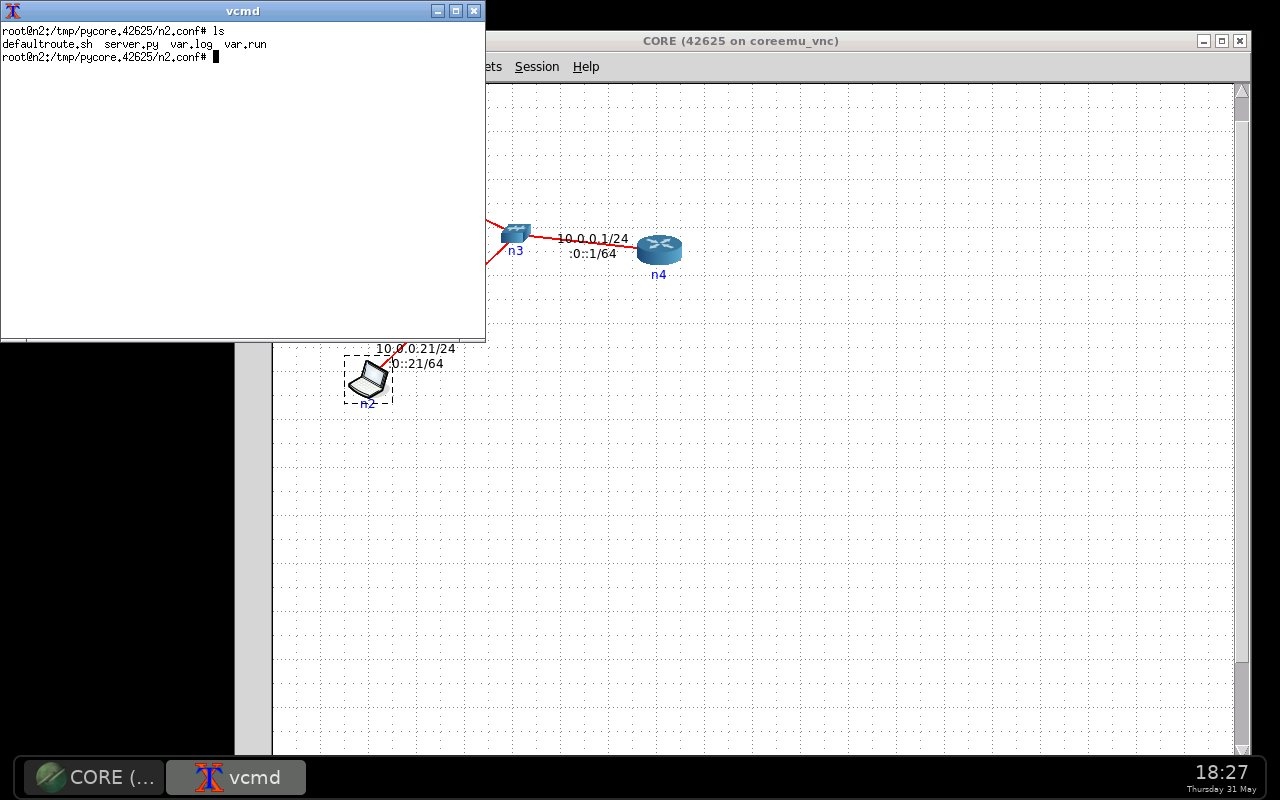

In [3]:
# Verificación gráfica...
from IPython.display import display, Image
imagen = !import -window root captura.jpg
display(Image('captura.jpg'))

# Verificación de ejecución de vnoded

Cada nodo de una emulación CORE es un proceso vnoded, al cual se comunica la GUI por un socket `AF_UNIX`.

Usando `ps -Ao cmd` podemos obtener todos los procesos en ejecución junto a su lína de invocación y agregar a un conjunto (ADT que no permite repetición) cada socket que encontremos. Una línea de `vnoded` tiene esta forma:
```bash
/usr/sbin/vnoded -v -c /tmp/pycore.42625/n1 -l /tmp/pycore.42625/n1.log -p /tmp/pycore.42625/n1.pid -C /tmp/pycore.42625/n1.conf
```

El argumento **`-c`** indica a continuación el socket de control. 
Este socket es necesario conocer para poder usar **`vcmd`**.

In [4]:
import subprocess

In [5]:
salida_ps = subprocess.check_output(['ps', '-Ao', 'cmd']).split('\n')
sockets = []
for linea in salida_ps:
    if not 'vnoded' in linea:
        continue
    # print(linea)
    argumentos = linea.split(' ')
    if '-c' in argumentos:
        indice = argumentos.index('-c')
        socket_path = argumentos[indice + 1]
        print("Socket para control de nodo: %s" % socket_path)
        sockets.append(socket_path)

Socket para control de nodo: /tmp/pycore.42625/n1
Socket para control de nodo: /tmp/pycore.42625/n2
Socket para control de nodo: /tmp/pycore.42625/n4


In [7]:
sesiones = set()
for socket in sockets:
    carpeta, archivo = socket.rsplit('/', 1)
    sesiones.add(carpeta)

SESSION_DIR = list(sesiones)[0]
os.environ['SESSION_DIR'] = SESSION_DIR
# Mostrando algo de info
display(HTML("""
Las sesiones encontradas fueron: <pre>{sesiones}</pre>
Guardando en la variable de ambiente
<pre style='color: red'>$SESSION_DIR = {SESSION_DIR}"</pre>
Preparado para hacer <pre style='color: green'>vcmd -c ${{SESSION_DIR}}/nodo -- comando</pre>
""".format(**locals())))

## Utilziación de la variable session
La variable `session` puede ser utilizada en comandos encerrada entre llaves. Por ejemplo, para utilizar vcmd...

### Dirección de n1

In [8]:
%%bash
vcmd -c ${SESSION_DIR}/n1 -- ip -4 --color addr show eth0

322: eth0@if323: <BROADCAST,MULTICAST,UP,LOWER_UP> mtu 1500 qdisc noqueue state UP group default qlen 1000 link-netnsid 0
    inet 10.0.0.20/24 brd 10.0.0.255 scope global eth0
       valid_lft forever preferred_lft forever


### Dirección de n2

In [9]:
%%bash
vcmd -c ${SESSION_DIR}/n2 -- ip -4 --color addr show eth0

324: eth0@if325: <BROADCAST,MULTICAST,UP,LOWER_UP> mtu 1500 qdisc noqueue state UP group default qlen 1000 link-netnsid 0
    inet 10.0.0.21/24 brd 10.0.0.255 scope global eth0
       valid_lft forever preferred_lft forever


### Escritura de un archivo en un nodo

In [10]:
%%writefile {SESSION_DIR}/n2.conf/server.py
import socket
sserver = socket.socket()
sserver.bind(('', 8080))
sserver.listen(1)
sock, addr = sserver.accept()
print(sock.recv(2000))
sock.close()

Overwriting /tmp/pycore.42625/n2.conf/server.py


In [16]:
import multiprocessing

def lanzar_en_n2():
    !vcmd -c {SESSION_DIR}/n2 -- python server.py
    
p = multiprocessing.Process(target=lanzar_en_n2)
p.start()

## Verificación de archivo en ejecución

In [21]:
!vcmd -c {SESSION_DIR}/n2 -- ps -eo pid,cmd

  PID CMD
    1 /usr/sbin/vnoded -v -c /tmp/pycore.42625/n2 -l /tmp/pycore.42625/n2.log -p
   31 python server.py
   40 ps -eo pid,cmd
